# <center> AAPL - Apple Inc. </center> 
#  <center> Time Series Forecasting with ARIMA and Prophet</center> 
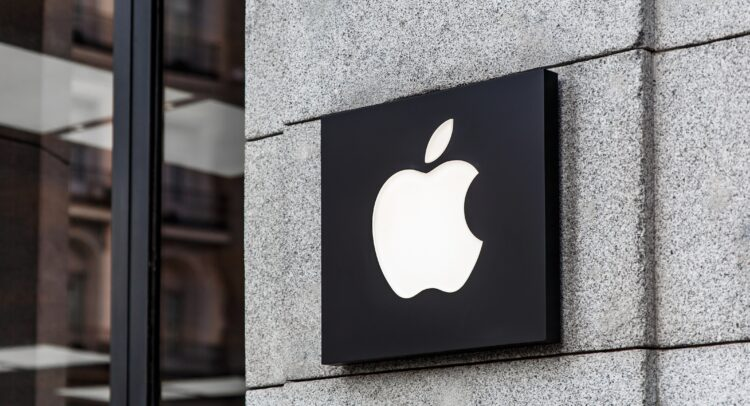

#### Context
In this project, we will study the stock AAPL (the ticker symbol for Apple Inc.). We will use the yfinance API to fetch a dataset of AAPL's historical stock prices over a period of time. This data is typically used for financial analysis, including studying trends in the stock price, predicting future prices, or analyzing the volatility of the stock.
</br></br>

#### Content
- Date: The specific date of the stock prices listed.
- Open: The price at which Apple's stock opened on that particular day.
- High: The highest price Apple’s stock reached during that day.
-Low: The lowest price Apple’s stock reached during that day.
- Close: The price at which Apple's stock closed on that day.
- Adj Close: The adjusted closing price, which reflects the stock's closing price after adjustments for any actions such as dividends or stock splits.
- Volume: The number of shares traded on that particular day.
</br></br>

We will use this dataset to perform analyses with Prophet and ARIMA models to predict future stock prices.

In [ ]:
# !pip install prophet
# !pip install yfinance
# !pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

## Import and read time series data

In [ ]:
df = yf.download("AAPL", period="5y", interval="1d")
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

## Data visualization

In [ ]:
# Create the figure and axes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))

# Close Price Plot
ax1.plot(df.index, df["Close"], color="red")
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("AAPL Close Price History")

# High Price Plot
ax2.plot(df.index, df["High"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("AAPL High Price History")

# Low Price Plot
ax3.plot(df.index, df["Low"], color="blue")
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Stock Price")
ax3.set_title("AAPL Low Price History")

# Volume Plot
ax4.plot(df.index, df["Volume"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Volume")
ax4.set_title("AAPL Volume History")

# Add vertical lines for each year in all plots
xcoords = pd.date_range(start=df.index.min(), end=df.index.max(), freq='YS')
for xc in xcoords:
    ax1.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax2.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax3.axvline(x=xc, color='black', linestyle='--', alpha=0.5)
    ax4.axvline(x=xc, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Long-term Trends

In [ ]:
# Linear Regression for Trend Analysis
X = np.arange(len(df)).reshape(-1, 1)  # Time as an independent variable
y = df['Close'].values  # Close price as the dependent variable

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Predict the trend
trend = model.predict(X)

# Plot the actual data and the trend line together
plt.figure(figsize=(10, 5))
plt.plot(df.index, y, label='Actual')
plt.plot(df.index, trend, label='Trend', color='red')
plt.title('Trend Line for AAPL Close Price')
plt.xlabel('Date')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

The upward trend in AAPL's stock price reflects Apple's continuous innovation, global expansion, strong brand loyalty, and integration of AI in their products, driving sustained investor confidence and growth.

## Data Preprocessing
We're likely focusing on analyzing and predicting the "Close" price of the AAPL stock, which represents the final price at which the stock was traded during a particular day. Hence, the other columns—Open, High, Low, Volume, and Adj Close—will be dropped because they are not directly relevant to this specific analysis.

In [ ]:
df2 = df[['Close']]
df2.head()

In [ ]:
results = seasonal_decompose(df2['Close'], model='additive', period=12)
results.plot()
plt.show()

## Stationarity

In [ ]:
df_diff = df2.dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

In [ ]:
from pmdarima.arima.utils import ndiffs
d_value = ndiffs(df2,test = "adf")
print("d value:", d_value)

In [ ]:
df_diff = df2.diff().dropna()
result = adfuller(df_diff)
table = [
    ['ADF Statistic', result[0]],
    ['P-value', result[1]],
    ['Conclusion', 'The time series is stationary' if result[1] < 0.05 else 'The time series is not stationary']
]
print(tabulate(table, headers=['Metrics', 'Value'], tablefmt='github'))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns

# Plot ACF
plot_acf(df2.Close.diff().dropna(), lags=20, ax=ax[0])  # ACF on the left
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('Autocorrelation')
ax[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(df2.Close.diff().dropna(), lags=20, ax=ax[1])  # PACF on the right
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Partial Autocorrelation')
ax[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

## Train / Test Split

In [ ]:
split_index = int(len(df2) * 0.8)
df_train = df2.iloc[:split_index]
df_test = df2.iloc[split_index:]
print(len(df_train),len(df_test))

In [ ]:
plt.figure(figsize=(10, 6))

# Plot x_train
plt.plot(range(len(df_train)), df_train, label='Train Data')

# Plot x_test
plt.plot(range(len(df_train), len(df_train) + len(df_test)), df_test, label='Test Data', color='orange')

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Train and Test Data')
plt.legend()

plt.show()

## ARIMA

#### Define orders automatically

In [ ]:
stepwise_fit = auto_arima(df2,trace=True,suppress_warnings=True)
print(stepwise_fit.summary())

#### Fit the model

In [ ]:
m_arima = sm.tsa.arima.ARIMA(df2, order=stepwise_fit.order)
m_arima = m_arima.fit()
m_arima.summary()

#### Plot residuals

In [ ]:
# Get the residuals from the fitted model
residuals = pd.DataFrame(m_arima.resid)

# Create a subplot with 2 plots :  residuals over time and histogral of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

# Plot residuals over time to check for any patterns or trends
ax1.plot(residuals)
ax2.hist(residuals, density=True)

#### Make prediction

In [ ]:
m_arima = sm.tsa.arima.ARIMA(df_train, order=stepwise_fit.order).fit()

# Predict values for the test set
start = len(df_train)
end = len(df_train) + len(df_test) - 1
pred_arima = m_arima.predict(start=start, end=end, typ='levels', dynamic=True)

pred_arima_series = pd.Series(pred_arima.values, index=df_test.index)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))

# Plot the actual test set values
plt.plot(df_test.index, df_test['Close'], label='Actual')

# Plot the predicted values from the ARIMA model
plt.plot(df_test.index, pred_arima_series, label='Predicted (ARIMA)', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Stock Prices (ARIMA)')
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_fct = df2.copy()
df_fct['fct_arima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_arima'] = pred_arima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_arima'], label='Forecast ARIMA', color='red')

plt.title('Original Data and Forecast (ARIMA)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

We have seen that simple ARIMA Model is not suitable for this data (There is seasonality in our data)

## SARIMA

In [ ]:
from pmdarima import auto_arima
smodel = auto_arima(
                    df2,
                    seasonal=True, 
                    m=7,
                    max_p=7, 
                    max_d=1, 
                    max_q=3, 
                    max_P=3, 
                    max_D=1, 
                    max_Q=2,
                    trace=True,
                    error_action='ignore',   # To print the progress of the fitting
                     suppress_warnings=True,  # Ignore potential errors
                     sn_jobs=-1)  # Use all available CPU cores
smodel.summary()

In [ ]:
# Get the residuals from the fitted SARIMAX model
residuals = smodel.resid()

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(0, linestyle='--', color='r')
plt.title('Residuals of SARIMAX Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Optional: Plot the histogram of residuals
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Make predictions for the test set
start = len(df_train)  # Starting index for predictions (after training set)
end = len(df_train) + len(df_test) - 1  # Ending index for predictions
predictions_sarima = smodel.predict(n_periods=len(df_test))  # Predict test set values

# Create a series for predicted values with the same index as the test data
pred_series = pd.Series(predictions_sarima.values, index=df_test.index)

# Plot actual vs predicted stock prices
plt.figure(figsize=(10, 6))

# Plot actual stock prices from the test set
plt.plot(df_test.index, df_test['Close'], label='Actual Stock Price', color='blue')

# Plot predicted stock prices
plt.plot(df_test.index, pred_series, label='Predicted Price', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SARIMA - Actual vs Predicted Stock Prices')
plt.legend()

# Show the plot
plt.show()

In [ ]:
df_fct['fct_sarima'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_sarima'] = predictions_sarima.values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='red')

plt.title('Original Data and Forecast (SARIMA)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
# TimeSeriesSplit for rolling cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
mae_sarima_list = []
mape_sarima_list = []
rmse_sarima_list = []

# Rolling cross-validation
for train_index, test_index in tscv.split(df2):
    # Split the data into rolling train and test sets
    train, test = df2.iloc[train_index], df2.iloc[test_index]
    
    # Make predictions on the test set
    predictions = smodel.predict(n_periods=len(test))
    
    # Calculate performance metrics
    mae_sarima = mean_absolute_error(test, predictions)
    mape_sarima = mean_absolute_percentage_error(test, predictions) * 100  # In percentage
    rmse_sarima = np.sqrt(mean_squared_error(test, predictions))
    
    # Append metrics to the respective lists
    mae_sarima_list.append(mae_sarima)
    mape_sarima_list.append(mape_sarima)
    rmse_sarima_list.append(rmse_sarima)

# Calculate average performance metrics across all folds
avg_mae_sarima = np.mean(mae_sarima_list)
avg_mape_sarima = np.mean(mape_sarima_list)
avg_rmse_sarima = np.mean(rmse_sarima_list)

# Print the average metrics
performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima]
})
print(performance.set_index('Metrics'))


## Prophet

In [ ]:
# Format data for prophet model using ds and y
# Resetting the index converts the datetime index into a regular column
df_train_prophet = df_train.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_train_prophet.head()

##### Fit

In [ ]:
%%time
m_prophet = Prophet()
m_prophet.fit(df_train_prophet)

##### Generate predictions

In [ ]:
fct_prophet = m_prophet.predict(df_test_prophet)
fct_prophet.head()

In [ ]:
df_fct['fct_prophet'] = None # Initialize the column with None values
df_fct.loc[df_test.index, 'fct_prophet'] = fct_prophet['yhat'].values

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(df_train.index, df_train, label='Train Data', color='blue')
plt.plot(df_test.index, df_test, label='Test Data', color='green')
plt.plot(df_fct.index, df_fct['fct_sarima'], label='Forecast SARIMA', color='red')
plt.plot(df_fct.index, df_fct['fct_prophet'], label='Forecast Prophet', color='orange')

plt.title('Original Data and Forecast (Prophet Vs SARIMA)')
plt.ylabel('Average Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()

#### Evaluate the model (Cross validation)

In [ ]:
df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
df_prophet.head()

In [ ]:
m = Prophet().fit(df_prophet)
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days')
df_cv.head()

## Comparison of metrics between ARIMA and Prophet models

In [ ]:
mae_prophet = mean_absolute_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])
mape_prophet = mean_absolute_percentage_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat'])*100
rmse_prophet = np.sqrt(mean_squared_error(y_true=df_cv['y'],
                   y_pred=df_cv['yhat']))

performance = pd.DataFrame({
    'Metrics': ['MAE', 'MAPE', 'RMSE'],
    'SARIMA': [avg_mae_sarima, f'{avg_mape_sarima:.2f}%', avg_rmse_sarima],
    'Prophet': [mae_prophet, f'{mape_prophet:.2f}%', rmse_prophet],
})

print(performance.set_index('Metrics'))

#### ✨ The more effective model is the one with the lower MAPE : PROPHET ✨

## Forecast for 2 years with teh best model

In [ ]:
steps = 2 * 365   # Number of steps to forecast (daily data)
df = df.reset_index() # Reset index

# Create future dataframe and predict
future_prophet = m_prophet.make_future_dataframe(periods=steps, freq='D')
prophet_forecast = m_prophet.predict(future_prophet)

plt.plot(df2.index, df2['Close'], label='Historical Data', color='blue')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast (2 Years)', color='green')

plt.title('Original Data and Forecasts (sARIMA vs Prophet)')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.legend()
plt.show()